##  Prediction experimental band gaps from Citrine database
This notebook is an example to show how to combined with other packages to predict compound's proprety.
We will use experimental band gaps fetch from Citrine's databases (https://citrination.com/)

### step 1. fetch data from Citrine
Here we use [matminer](https://hackingmaterials.github.io/)'s `retrieve_Citrine` module to contract with Citrine's databases. Install matminer is easy.

```bash
$ pip install matminer  # install matminer
```

In [1]:
import matminer as mm
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval
mm.__version__

'0.2.1'

In [3]:
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval

# your Citrine API key
api_key = 'B8ovDFnrqxbf9UsSXKGRkAtt'
c = CitrineDataRetrieval(api_key)

json = c.get_api_data(property='band gap', data_type='experimental', max_results=1200)
df = c.get_dataframe(json, show_columns=['chemicalFormula', 'Band gap'] )

# filter out NaN
df = df.dropna(axis=0, how='all')
df = df.rename(columns={'Band gap': 'band_gap', 'chemicalFormula': 'formula'})
df.head()

  0%|                                                                                                                                                                                                                             | 0/1200 [00:00<?, ?it/s]D:\Miniconda3\envs\xenonpy\lib\site-packages\matminer\data_retrieval\retrieve_Citrine.py:161: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  p_df.set_value(counter, prop["name"], parse_scalars(prop["scalars"]))
D:\Miniconda3\envs\xenonpy\lib\site-packages\matminer\data_retrieval\retrieve_Citrine.py:179: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  p_df.set_value(counter, prop["name"] + "-" + prop_key, prop[prop_key])
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

,formula,band_gap
system,,
1,Bi2Te3,0.153
2,Mg2Ge1,0.567
3,Co1Si1,0.045
4,Na1Br1,7.025
5,Ca2Sn1,0.9


We want to save it for next using.

In [8]:
from xenonpy.utils import Saver

save = Saver(dataset='bg_expt')  # use Saver
save(df)
save

1cd35e7a006a11e8b29f6045cb9d9b45


Dataset: bg_expt with:
temp_data: 1

Convert formula to composition. Also convert `band_gap` to `np.float`

> **warning**: formula H1p1 is illegal. drop it!

In [9]:
from matminer.utils.conversions import str_to_composition

# remove illegal data
mask = df['formula'].str.contains('p1')
df = df.loc[~mask, :]

df['band_gap'] = df['band_gap'].astype('float')
df["composition"] = str_to_composition(df["formula"])
df.head()

,formula,band_gap,composition
system,,,
1,Bi2Te3,0.153,"(Bi, Te)"
2,Mg2Ge1,0.567,"(Mg, Ge)"
3,Co1Si1,0.045,"(Co, Si)"
4,Na1Br1,7.025,"(Na, Br)"
5,Ca2Sn1,0.900,"(Ca, Sn)"


In [10]:
save(df)  # save it

22da643e006a11e8b20e6045cb9d9b45


Let's calculate elemental descriptors and draw a heatmap.

converting 1196 compounds
2789d1a2006a11e89ec96045cb9d9b45


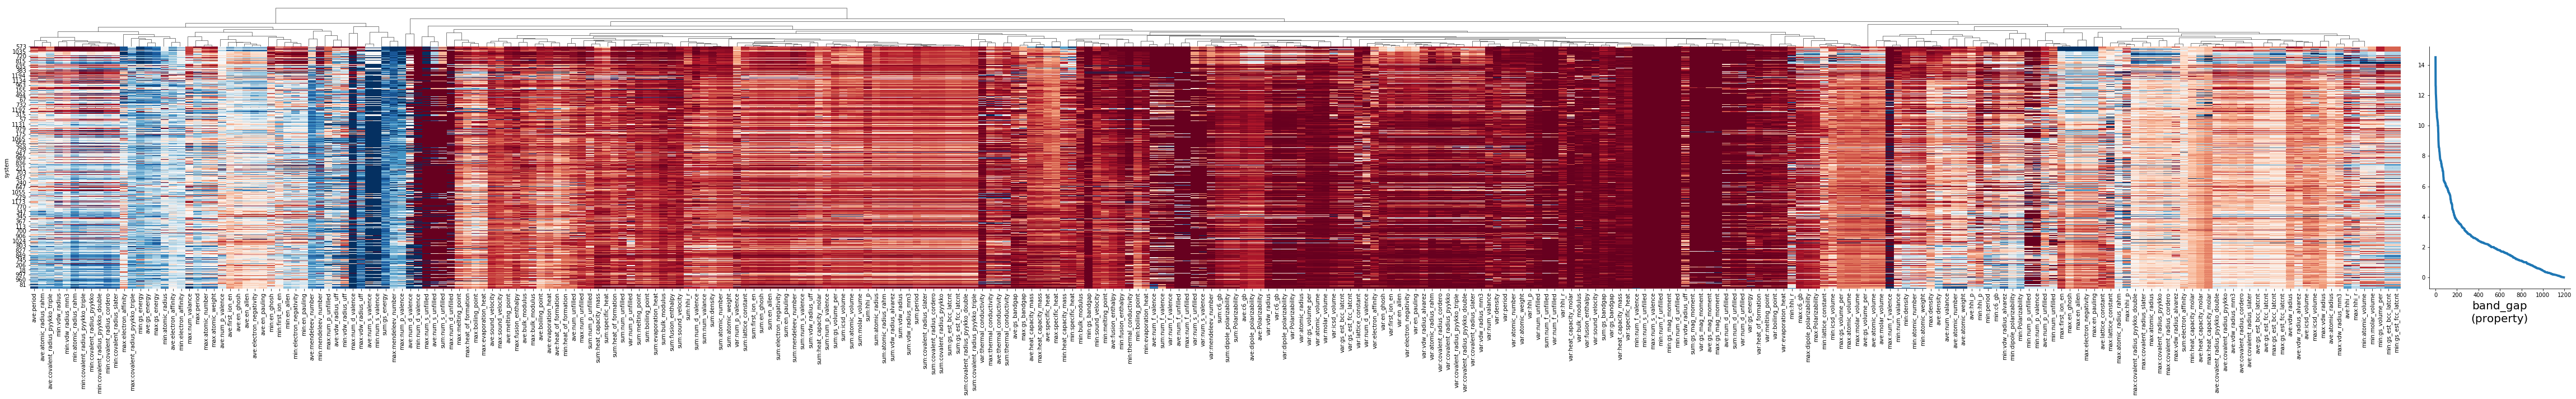

In [11]:
from xenonpy.descriptor import ElementDesc

desc = ElementDesc()  # use it with default paramters
df_sorted = df.sort_values(by='band_gap', ascending=False)

desc_bg = desc.fit_transform(df_sorted)
save(descriptor=desc_bg)

from xenonpy.visualization import DescHeatmap

hmap = DescHeatmap(
    save=dict(fname='band_gap_desc_expt.png', dpi=150, bbox_inches='tight', transparent=False),
    method='complete', bc=False, figsize=(70, 10))

hmap.fit(desc_bg)
hmap.draw(df_sorted['band_gap'])

## Try random forest training to predict  bang gap's experimental data

There are many packages do machine learning in python. In this sample we use scikit-learn. 

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

import numpy as np

# box-cox transfer
bg_bc, lmd = boxcox(df_sorted['band_gap'])
save(band_gap_bc=bg_bc, lmd=lmd)

# standarded descriptor
scaler = StandardScaler()
desc_bg_scale = scaler.fit_transform(desc_bg)
save(descriptor_scale=desc_bg_scale)

#%% random forest
X_train, X_test, y_train, y_test = train_test_split(desc_bg_scale, bg_bc, test_size=0.2, random_state=0)
regr = RandomForestRegressor(max_depth=10, random_state=42, n_jobs=-1, verbose=0)
regr.fit(X_train, y_train)
y_true, y_pred = y_test, regr.predict(X_test)

print('R2 = ' + str(round(regr.score(X_train, y_train), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true, y_pred)))

2f954628006a11e8ad4d6045cb9d9b45
2f95bb26006a11e8a4fa6045cb9d9b45
2f97909e006a11e884286045cb9d9b45
R2 = 0.929
RMSE = 0.420


That's sound good! Let's plot it with seaborn for simple!

33b364b0006a11e8b7eb6045cb9d9b45
33c03ae4006a11e8b4dd6045cb9d9b45
33c4d092006a11e8a6306045cb9d9b45
33c545fa006a11e89ffc6045cb9d9b45
33c5e274006a11e88dd66045cb9d9b45


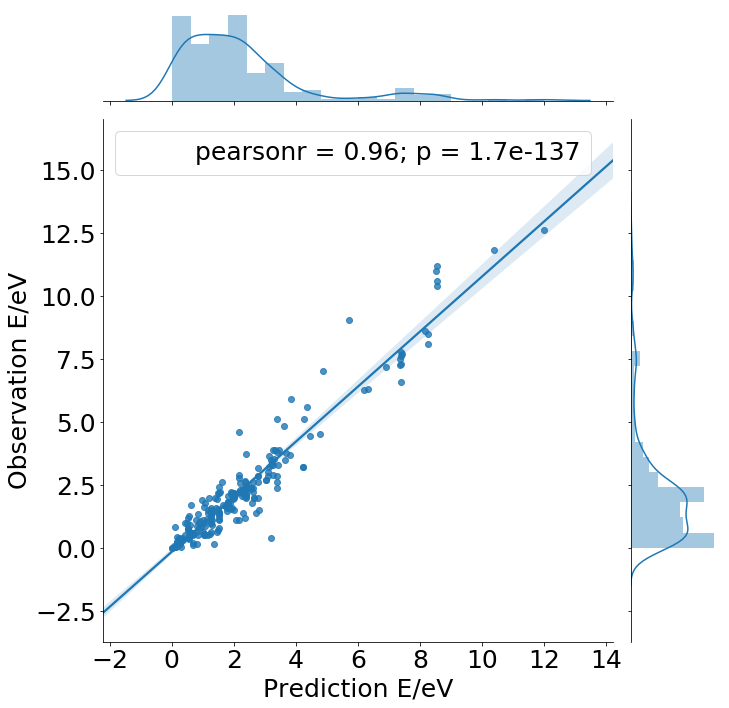

In [13]:
import seaborn as sb
import matplotlib as mpl
from scipy.special import inv_boxcox

y_train = inv_boxcox(y_train, lmd)
y_test = inv_boxcox(y_test, lmd)
y_pred = inv_boxcox(y_pred, lmd)

save(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred)

with mpl.rc_context(rc={'font.size': 25}):
    ax = sb.jointplot(y_pred, y_test, kind="reg", size=10)
    ax.set_axis_labels('Prediction E/eV', 'Observation E/eV')